In [1]:
!pip install -q lightgbm polars

In [2]:
import polars as pl
import numpy as np
import lightgbm as lgb
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import optuna
from sklearn.model_selection import train_test_split



/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


In [3]:
DATA_PATH = "/kaggle/input/new-features/features_feb2024_sep2024_to_jan2025_withneg.parquet"

df = pl.read_parquet(DATA_PATH)
print(df.shape)
print(df.columns)

(21697473, 17)
['customer_id', 'item_id', 'label', 'brand', 'category_l1', 'age_group', 'price', 'user_tx_cnt', 'user_avg_spend', 'last_tx_date', 'recency_days', 'item_popularity', 'repurchase_cnt', 'brand_affinity', 'category_affinity', 'agegroup_affinity', 'month']


In [4]:
print(df.glimpse())

Rows: 21697473
Columns: 17
$ customer_id                 <str> '4267786', '7904238', '2929609', '4591543', '360075', '7884105', '7551536', '7907776', '3797940', '2593493'
$ item_id                     <str> '0007010000887', '6498000000003', '6429000000001', '2707000000001', '5617000000001', '3523000000135', '1512000000004', '5952000000002', '2482000000003', '3901000000005'
$ label                       <i32> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ brand                       <str> 'Pigeon', 'Bình sữa, phụ kiện Aga-ae', 'Dr. Papie (Việt Nam)', 'Chupa chups', 'Zott', 'Không xác định', 'Lineabon', 'CleAntong', 'Nestle NAN Optipro PLUS', 'Relkon'
$ category_l1                 <str> 'Babycare', 'Babycare', 'Hóa mỹ phẩm cho bé', 'Thực phẩm cho bé', 'Thực phẩm cho bé', 'Thời trang', 'TPCN', 'Babycare', 'Sữa', 'Thực phẩm cho bé'
$ age_group                   <str> 'Không xác định', '3M-6M', '0-36M', 'Không xác định', 'Không xác định', 'Không xác định', 'Không xác định', 'Không xác định', '0-6M', 'Từ 3Y

In [5]:
# Chuyển đổi cột price từ Decimal sang Float64
df = df.with_columns(
    pl.col("price").cast(pl.Float64)
)


In [6]:
CUSTOMER_COL = "customer_id"
ITEM_COL = "item_id"
TARGET = "label"
drop_col = ["brand", "category_l1", "price", "last_tx_date", "age_group"]
ID_COLS = [CUSTOMER_COL, ITEM_COL]

In [7]:
# Kiểm tra tỷ lệ nhãn
print("Số lượng nhãn:", df.select(TARGET).group_by(TARGET).len())
# Nếu chỉ hiện ra 1 dòng (ví dụ toàn số 0), thì lỗi nằm ở khâu tạo dữ liệu target.

Số lượng nhãn: shape: (2, 2)
┌───────┬──────────┐
│ label ┆ len      │
│ ---   ┆ ---      │
│ i32   ┆ u32      │
╞═══════╪══════════╡
│ 1     ┆ 13125399 │
│ 0     ┆ 8572074  │
└───────┴──────────┘


In [8]:
non_numeric_cols = [
    c for c, t in df.schema.items()
    if t not in [
        pl.Int8, pl.Int16, pl.Int32, pl.Int64,
        pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
        pl.Float32, pl.Float64
    ]
    and c not in ID_COLS + [TARGET] + drop_col
]

print("Non-numeric feature columns:", non_numeric_cols)


Non-numeric feature columns: []


In [9]:
FEATURES = [
    c for c in df.columns
    if c not in ID_COLS + [TARGET] + drop_col
]

print("Num features:", len(FEATURES))

Num features: 9


In [10]:
# --- 1. CHUẨN BỊ DỮ LIỆU ---
# Giữ nguyên cách lấy dữ liệu của bạn
X = df.select(FEATURES).to_numpy()
y = df.select(TARGET).to_numpy().ravel()

# Tách ra 1 phần validation set ĐỂ TUNE (Chỉ dùng trong quá trình tìm tham số)
# Lưu ý: shuffle=False cực quan trọng cho RecSys/Time-series để không bị lộ tương lai
X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False 
)
# Thêm tham số params={'feature_pre_filter': False} ngay lúc tạo Dataset
dtrain_tune = lgb.Dataset(
    X_train_tune, 
    label=y_train_tune, 
    params={'feature_pre_filter': False}  # <--- QUAN TRỌNG: Khai báo ngay ở đây
)

dval_tune = lgb.Dataset(
    X_val_tune, 
    label=y_val_tune, 
    reference=dtrain_tune, 
    params={'feature_pre_filter': False}  # <--- QUAN TRỌNG: Khai báo ngay ở đây
)

In [11]:
def objective(trial):
    param_grid = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "seed": 42,
        "n_jobs": -1,
        
        # --- SỬA LỖI Ở ĐÂY ---
        "feature_pre_filter": False,  # Bắt buộc khi tune min_data_in_leaf
        
        # Các tham số cần tune
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
    }

    model_trial = lgb.train(
        param_grid,
        dtrain_tune,
        valid_sets=[dval_tune],
        num_boost_round=500,
        callbacks=[
            lgb.early_stopping(stopping_rounds=20),
            lgb.log_evaluation(0)
        ]
    )
    
    return model_trial.best_score['valid_0']['auc']

In [12]:

# --- 3. CHẠY TỐI ƯU HÓA (FINE-TUNE) ---
print(">>> Đang bắt đầu Fine-tune tham số (Optuna)...")
study = optuna.create_study(direction="maximize") # Maximize AUC
study.optimize(objective, n_trials=30) # Chạy thử 30 cấu hình khác nhau (Bạn có thể tăng lên 50-100 nếu máy mạnh)

print(f">>> Đã tìm thấy tham số tốt nhất: {study.best_params}")


[I 2025-12-26 12:55:17,546] A new study created in memory with name: no-name-9ce5bd3c-a591-410b-ab9f-61092efd13d8


>>> Đang bắt đầu Fine-tune tham số (Optuna)...
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 12:55:35,495] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.010057457628939889, 'num_leaves': 174, 'max_depth': 7, 'min_data_in_leaf': 44, 'lambda_l1': 4.481185419325958e-06, 'lambda_l2': 7.407172453005913, 'feature_fraction': 0.7904228415383627, 'bagging_fraction': 0.9264676505039906, 'bagging_freq': 4}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 12:55:54,593] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.034729376242322106, 'num_leaves': 51, 'max_depth': 13, 'min_data_in_leaf': 37, 'lambda_l1': 0.0010516054654396286, 'lambda_l2': 0.0005161723260439676, 'feature_fraction': 0.904017284176463, 'bagging_fraction': 0.6105851750213726, 'bagging_freq': 7}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 12:56:17,730] Trial 2 finished with value: 1.0 and parameters: {'learning_rate': 0.06523664606156485, 'num_leaves': 169, 'max_depth': 15, 'min_data_in_leaf': 78, 'lambda_l1': 1.8007550081605527e-08, 'lambda_l2': 2.069884726900542e-07, 'feature_fraction': 0.9220761263659268, 'bagging_fraction': 0.6703634601952995, 'bagging_freq': 2}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 12:56:45,894] Trial 3 finished with value: 1.0 and parameters: {'learning_rate': 0.011521209244159007, 'num_leaves': 183, 'max_depth': 11, 'min_data_in_leaf': 99, 'lambda_l1': 9.298210029707752e-08, 'lambda_l2': 4.2383152394284485e-08, 'feature_fraction': 0.8243049234362225, 'bagging_fraction': 0.7268810986335226, 'bagging_freq': 6}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 12:57:10,710] Trial 4 finished with value: 1.0 and parameters: {'learning_rate': 0.04569178842391433, 'num_leaves': 97, 'max_depth': 15, 'min_data_in_leaf': 48, 'lambda_l1': 6.81799879750005e-07, 'lambda_l2': 0.12129417135969536, 'feature_fraction': 0.7472373880611929, 'bagging_fraction': 0.9308364782338234, 'bagging_freq': 7}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 12:57:42,737] Trial 5 finished with value: 1.0 and parameters: {'learning_rate': 0.016647588073423213, 'num_leaves': 160, 'max_depth': 11, 'min_data_in_leaf': 34, 'lambda_l1': 2.761273029031183e-06, 'lambda_l2': 3.9901201568330595e-07, 'feature_fraction': 0.7484827529413156, 'bagging_fraction': 0.9611544095252236, 'bagging_freq': 4}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 12:58:05,935] Trial 6 finished with value: 1.0 and parameters: {'learning_rate': 0.014153775415846807, 'num_leaves': 65, 'max_depth': 10, 'min_data_in_leaf': 53, 'lambda_l1': 0.0004447315758702282, 'lambda_l2': 9.68197674618784e-05, 'feature_fraction': 0.9466877339107163, 'bagging_fraction': 0.8273404177751496, 'bagging_freq': 3}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 12:58:28,015] Trial 7 finished with value: 1.0 and parameters: {'learning_rate': 0.011048685838860726, 'num_leaves': 25, 'max_depth': 6, 'min_data_in_leaf': 72, 'lambda_l1': 0.00041542467968117745, 'lambda_l2': 0.0003810293084590549, 'feature_fraction': 0.7477226952506948, 'bagging_fraction': 0.6555111243457639, 'bagging_freq': 3}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 12:58:53,119] Trial 8 finished with value: 1.0 and parameters: {'learning_rate': 0.017360703861522823, 'num_leaves': 71, 'max_depth': 6, 'min_data_in_leaf': 88, 'lambda_l1': 0.0032021520507937054, 'lambda_l2': 0.00021397928675297785, 'feature_fraction': 0.7885895692933957, 'bagging_fraction': 0.6415721259868129, 'bagging_freq': 6}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 12:59:15,860] Trial 9 finished with value: 1.0 and parameters: {'learning_rate': 0.07294099115617583, 'num_leaves': 84, 'max_depth': 15, 'min_data_in_leaf': 89, 'lambda_l1': 5.590550800714568e-05, 'lambda_l2': 2.6077832962586393e-08, 'feature_fraction': 0.774463121781596, 'bagging_fraction': 0.635990387003356, 'bagging_freq': 1}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 12:59:31,743] Trial 10 finished with value: 1.0 and parameters: {'learning_rate': 0.027408395905181702, 'num_leaves': 131, 'max_depth': 8, 'min_data_in_leaf': 27, 'lambda_l1': 1.3777610827622935, 'lambda_l2': 8.49932454920989, 'feature_fraction': 0.6381373835683462, 'bagging_fraction': 0.8736314450720387, 'bagging_freq': 5}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 12:59:49,605] Trial 11 finished with value: 1.0 and parameters: {'learning_rate': 0.028958880716375437, 'num_leaves': 20, 'max_depth': 9, 'min_data_in_leaf': 39, 'lambda_l1': 0.039442337079026044, 'lambda_l2': 0.05371586098063672, 'feature_fraction': 0.8731405991133168, 'bagging_fraction': 0.7606388807174361, 'bagging_freq': 4}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:00:00,858] Trial 12 finished with value: 1.0 and parameters: {'learning_rate': 0.04431496770636222, 'num_leaves': 136, 'max_depth': 13, 'min_data_in_leaf': 62, 'lambda_l1': 1.6890664316663683e-05, 'lambda_l2': 9.849258868126453, 'feature_fraction': 0.989350998977859, 'bagging_fraction': 0.8820508042072445, 'bagging_freq': 7}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:00:20,628] Trial 13 finished with value: 1.0 and parameters: {'learning_rate': 0.021639405548023495, 'num_leaves': 49, 'max_depth': 5, 'min_data_in_leaf': 21, 'lambda_l1': 0.027100158768909654, 'lambda_l2': 0.023273055474784386, 'feature_fraction': 0.8537542259299284, 'bagging_fraction': 0.9897923448143682, 'bagging_freq': 5}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:00:50,140] Trial 14 finished with value: 1.0 and parameters: {'learning_rate': 0.046741975214025795, 'num_leaves': 115, 'max_depth': 13, 'min_data_in_leaf': 42, 'lambda_l1': 5.679795862270824e-06, 'lambda_l2': 6.581944261256749e-06, 'feature_fraction': 0.661920684761891, 'bagging_fraction': 0.807922694834366, 'bagging_freq': 5}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:01:14,556] Trial 15 finished with value: 1.0 and parameters: {'learning_rate': 0.09715519148266202, 'num_leaves': 197, 'max_depth': 8, 'min_data_in_leaf': 59, 'lambda_l1': 0.005594000093039061, 'lambda_l2': 0.0033114000146788588, 'feature_fraction': 0.8994883612318343, 'bagging_fraction': 0.7234628853032352, 'bagging_freq': 3}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:01:30,373] Trial 16 finished with value: 1.0 and parameters: {'learning_rate': 0.03599593899618973, 'num_leaves': 148, 'max_depth': 13, 'min_data_in_leaf': 31, 'lambda_l1': 1.2727851485941504, 'lambda_l2': 0.5439454208617426, 'feature_fraction': 0.6869336371036867, 'bagging_fraction': 0.8661763836350405, 'bagging_freq': 6}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:02:02,333] Trial 17 finished with value: 1.0 and parameters: {'learning_rate': 0.05290155427855244, 'num_leaves': 116, 'max_depth': 7, 'min_data_in_leaf': 45, 'lambda_l1': 8.873434240095497e-07, 'lambda_l2': 8.076522449945196e-06, 'feature_fraction': 0.624148242672874, 'bagging_fraction': 0.8097427711638707, 'bagging_freq': 5}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:02:28,938] Trial 18 finished with value: 1.0 and parameters: {'learning_rate': 0.0229542355032381, 'num_leaves': 200, 'max_depth': 8, 'min_data_in_leaf': 61, 'lambda_l1': 0.01954959828218242, 'lambda_l2': 0.006843178155777203, 'feature_fraction': 0.825552884893945, 'bagging_fraction': 0.7304857677308917, 'bagging_freq': 3}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:02:43,121] Trial 19 finished with value: 1.0 and parameters: {'learning_rate': 0.035758509599254855, 'num_leaves': 151, 'max_depth': 12, 'min_data_in_leaf': 30, 'lambda_l1': 9.444918362154153, 'lambda_l2': 0.7701578865869255, 'feature_fraction': 0.6932395595803855, 'bagging_fraction': 0.9043262834729558, 'bagging_freq': 6}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:03:15,506] Trial 20 finished with value: 1.0 and parameters: {'learning_rate': 0.06554464864164716, 'num_leaves': 113, 'max_depth': 7, 'min_data_in_leaf': 46, 'lambda_l1': 3.422473482573056e-07, 'lambda_l2': 8.627636754270715e-06, 'feature_fraction': 0.600149920251421, 'bagging_fraction': 0.8322516269253402, 'bagging_freq': 4}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:03:48,691] Trial 21 finished with value: 1.0 and parameters: {'learning_rate': 0.021729969404078408, 'num_leaves': 196, 'max_depth': 8, 'min_data_in_leaf': 58, 'lambda_l1': 4.4970253597811226e-05, 'lambda_l2': 1.0523256565887783e-05, 'feature_fraction': 0.8132489744421074, 'bagging_fraction': 0.7597246187351201, 'bagging_freq': 2}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:04:04,891] Trial 22 finished with value: 1.0 and parameters: {'learning_rate': 0.023303371246316634, 'num_leaves': 174, 'max_depth': 10, 'min_data_in_leaf': 67, 'lambda_l1': 0.2034396518397854, 'lambda_l2': 0.8837212296333995, 'feature_fraction': 0.8445942992802816, 'bagging_fraction': 0.9220763366307559, 'bagging_freq': 2}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:04:26,061] Trial 23 finished with value: 1.0 and parameters: {'learning_rate': 0.09689148970561992, 'num_leaves': 150, 'max_depth': 5, 'min_data_in_leaf': 21, 'lambda_l1': 1.1590004056392077e-07, 'lambda_l2': 0.5364251868148129, 'feature_fraction': 0.6821805404731286, 'bagging_fraction': 0.909862185153509, 'bagging_freq': 4}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:04:50,865] Trial 24 finished with value: 1.0 and parameters: {'learning_rate': 0.014327124847398917, 'num_leaves': 179, 'max_depth': 7, 'min_data_in_leaf': 51, 'lambda_l1': 4.941034097316656e-05, 'lambda_l2': 1.3511024807442558e-05, 'feature_fraction': 0.7189760339625678, 'bagging_fraction': 0.853063850785049, 'bagging_freq': 1}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:05:03,159] Trial 25 finished with value: 1.0 and parameters: {'learning_rate': 0.022748457036620325, 'num_leaves': 181, 'max_depth': 9, 'min_data_in_leaf': 69, 'lambda_l1': 6.26801941021493e-05, 'lambda_l2': 3.7000827200592377, 'feature_fraction': 0.8446080562510607, 'bagging_fraction': 0.7709416740612599, 'bagging_freq': 2}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:05:25,082] Trial 26 finished with value: 1.0 and parameters: {'learning_rate': 0.09902928469786994, 'num_leaves': 166, 'max_depth': 5, 'min_data_in_leaf': 20, 'lambda_l1': 1.7734556919722437e-08, 'lambda_l2': 0.35161786668192746, 'feature_fraction': 0.784560972679997, 'bagging_fraction': 0.9311059572373757, 'bagging_freq': 4}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:05:48,576] Trial 27 finished with value: 1.0 and parameters: {'learning_rate': 0.013061517181551897, 'num_leaves': 142, 'max_depth': 6, 'min_data_in_leaf': 51, 'lambda_l1': 6.050913563147535e-08, 'lambda_l2': 4.457407102139696e-05, 'feature_fraction': 0.7108458038472125, 'bagging_fraction': 0.96122532831088, 'bagging_freq': 1}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:06:02,047] Trial 28 finished with value: 1.0 and parameters: {'learning_rate': 0.016321824314350475, 'num_leaves': 180, 'max_depth': 9, 'min_data_in_leaf': 74, 'lambda_l1': 6.989495802898333e-05, 'lambda_l2': 3.170896402305164, 'feature_fraction': 0.7222824724579183, 'bagging_fraction': 0.848913499449152, 'bagging_freq': 1}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 20 rounds


[I 2025-12-26 13:06:22,343] Trial 29 finished with value: 1.0 and parameters: {'learning_rate': 0.010046044591684821, 'num_leaves': 161, 'max_depth': 5, 'min_data_in_leaf': 82, 'lambda_l1': 1.7997447841864487e-08, 'lambda_l2': 0.12333367253230995, 'feature_fraction': 0.776421362654344, 'bagging_fraction': 0.767244098319649, 'bagging_freq': 2}. Best is trial 0 with value: 1.0.


Early stopping, best iteration is:
[1]	valid_0's auc: 1
>>> Đã tìm thấy tham số tốt nhất: {'learning_rate': 0.010057457628939889, 'num_leaves': 174, 'max_depth': 7, 'min_data_in_leaf': 44, 'lambda_l1': 4.481185419325958e-06, 'lambda_l2': 7.407172453005913, 'feature_fraction': 0.7904228415383627, 'bagging_fraction': 0.9264676505039906, 'bagging_freq': 4}


In [13]:

# --- 4. TRAIN LẠI MODEL CUỐI CÙNG (QUAN TRỌNG) ---
# Lấy tham số tốt nhất vừa tìm được áp dụng vào toàn bộ dữ liệu (X, y)
best_params = study.best_params
best_params.update({
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "seed": 42
})

full_train_set = lgb.Dataset(X, label=y)

# Model cuối cùng này sẽ thay thế biến 'model' cũ của bạn
model = lgb.train(
    best_params,
    full_train_set,
    num_boost_round=1000 # Tăng số vòng lặp cho model chính thức
)

print(">>> Đã train xong model cuối cùng với bộ tham số tối ưu.")

>>> Đã train xong model cuối cùng với bộ tham số tối ưu.


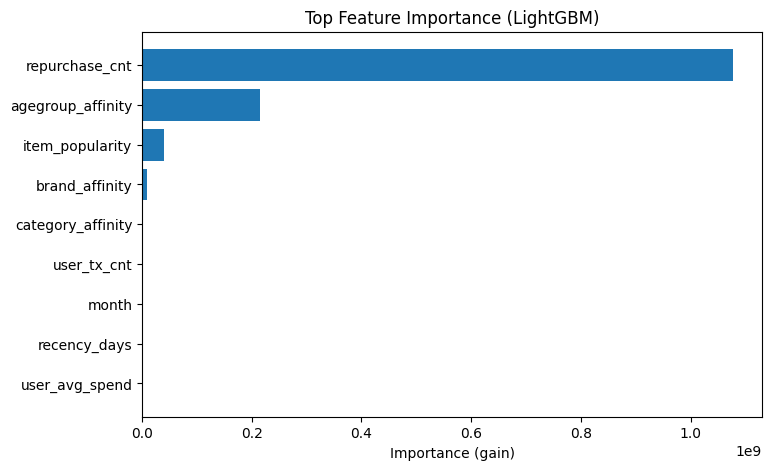

In [14]:
importance = model.feature_importance(importance_type="gain")
feat_imp = sorted(
    zip(FEATURES, importance),
    key=lambda x: x[1],
    reverse=True
)

top_k = 15
names = [x[0] for x in feat_imp[:top_k]]
values = [x[1] for x in feat_imp[:top_k]]

plt.figure(figsize=(8, 5))
plt.barh(names[::-1], values[::-1])
plt.title("Top Feature Importance (LightGBM)")
plt.xlabel("Importance (gain)")
plt.show()


In [15]:
import pandas as pd
# 1. Tạo DataFrame chứa tên feature và độ quan trọng
df_imp = pd.DataFrame({
    'feature': FEATURES,
    'importance': importance
})

# 2. Tìm các feature có độ quan trọng bằng 0
zero_imp_features = df_imp[df_imp['importance'] == 0]['feature'].tolist()
print(f"Có {len(zero_imp_features)} feature bị loại (Importance = 0):", zero_imp_features)

# 3. Tạo danh sách feature mới để train lại
SELECTED_FEATURES = df_imp[df_imp['importance'] > 0]['feature'].tolist()

print("\nDanh sách feature giữ lại:", SELECTED_FEATURES)

# --- Sau đó bạn dùng SELECTED_FEATURES để train lại model ---
# X_train_selected = X_train[SELECTED_FEATURES]
# ...

Có 0 feature bị loại (Importance = 0): []

Danh sách feature giữ lại: ['user_tx_cnt', 'user_avg_spend', 'recency_days', 'item_popularity', 'repurchase_cnt', 'brand_affinity', 'category_affinity', 'agegroup_affinity', 'month']


In [16]:
# Lấy giá trị importance cao nhất (của repurchase_cnt)
max_importance = df_imp['importance'].max()

# Ngưỡng cắt: ví dụ feature nào yếu hơn 0.1% so với feature mạnh nhất thì bỏ
threshold = max_importance * 0.001 

# Lọc feature
low_imp_features = df_imp[df_imp['importance'] <= threshold]['feature'].tolist()
SELECTED_FEATURES_OPTIMIZED = df_imp[df_imp['importance'] > threshold]['feature'].tolist()

print(f"Ngưỡng lại bỏ (Threshold): {threshold}")
print(f"Các feature quá yếu bị loại: {low_imp_features}")
print(f"Danh sách feature tối ưu giữ lại: {SELECTED_FEATURES_OPTIMIZED}")

Ngưỡng lại bỏ (Threshold): 1076549.7793983647
Các feature quá yếu bị loại: ['user_tx_cnt', 'user_avg_spend', 'recency_days', 'month']
Danh sách feature tối ưu giữ lại: ['item_popularity', 'repurchase_cnt', 'brand_affinity', 'category_affinity', 'agegroup_affinity']


In [17]:
scores = model.predict(X)

df_pred = df.select([CUSTOMER_COL, ITEM_COL]).with_columns(
    pl.Series("score", scores)
)


In [18]:
topk = (
    df_pred
    .sort([CUSTOMER_COL, "score"], descending=[False, True])
    .group_by(CUSTOMER_COL)
    .head(10)
)


In [19]:
pred_json = (
    topk
    .group_by(CUSTOMER_COL)
    .agg(pl.col(ITEM_COL))
)

pred_dict = {
    str(row[CUSTOMER_COL]): row[ITEM_COL]
    for row in pred_json.to_dicts()
}

with open("pred_feb2025.json", "w") as f:
    json.dump(pred_dict, f)

print("✅ Saved pred_feb2025.json")


✅ Saved pred_feb2025.json


In [20]:
GT_PATH = "/kaggle/input/final-groundtruth/final_groundtruth.csv"
gt_df = pl.read_csv(GT_PATH)

gt = {
    str(row["customer_id"]): row["item_id"]
    for row in gt_df.to_dicts()
}


In [21]:
# Cách dùng Polars native (Nhanh hơn)
hist_df = (
    df.filter(pl.col(TARGET) == 1)
    .group_by(CUSTOMER_COL)
    .agg(pl.col(ITEM_COL).alias("items")) # Gom các item thành list
)

# Chuyển đổi sang dictionary để tra cứu nhanh (nếu cần dùng cho đoạn sau)
# Lưu ý: Ép kiểu str cho User ID để khớp với format bạn cần
hist = {
    str(row[CUSTOMER_COL]): set(row["items"]) 
    for row in hist_df.iter_rows(named=True)
}

In [22]:
def precision_at_k(pred, gt, hist, filter_bought_items=True, K=10):
    precisions = []
    ncold_start = 0
    cold_start_users = []

    for user in gt.keys():
        if (user not in hist) or (user not in pred):
            ncold_start += 1
            cold_start_users.append(user)
            continue

        relevant_items = set(gt[user])
        if filter_bought_items:
            relevant_items -= set(hist[user])

        hits = len(set(pred[user][:K]) & relevant_items)
        precisions.append(hits / K)

    return np.mean(precisions), cold_start_users


In [23]:
import json
import numpy as np

# Tên file bạn muốn lưu
output_filename = "pred_feb2025.json"

# Hàm phụ trợ: Giúp chuyển đổi số của Numpy (int64) sang số Python thường (int)
# Để tránh lỗi "Object of type int64 is not JSON serializable"
def numpy_converter(obj):
    if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                        np.int16, np.int32, np.int64, np.uint8,
                        np.uint16, np.uint32, np.uint64)):
        return int(obj)
    elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    return obj

# Thực hiện ghi file
try:
    with open(output_filename, "w", encoding='utf-8') as f:
        json.dump(pred_dict, f, default=numpy_converter)
        
    print(f"✅ Xuất file thành công: {output_filename}")
    print(f"👉 Hãy tải về tại thư mục Output (bên phải màn hình Kaggle).")
    
except NameError:
    print("❌ Lỗi: Bạn chưa chạy đoạn code tạo biến 'pred_dict' ở trên.")
except Exception as e:
    print(f"❌ Có lỗi xảy ra: {e}")

✅ Xuất file thành công: pred_feb2025.json
👉 Hãy tải về tại thư mục Output (bên phải màn hình Kaggle).


In [24]:
# ==========================================
# 1. CẤU HÌNH THAM SỐ
# ==========================================
FILE_PATH = "/kaggle/input/feature-engineer/train_features_feb2024_sep2024_to_jan2025 (1).parquet"  # Thay tên file feature/preprocessing của bạn vào đây (csv hoặc parquet)
RECENCY_LIMIT = 1000000  # 🟢 CHỈNH SỐ NGÀY TẠI ĐÂY (30, 60, 90...)

# ==========================================
# 2. XỬ LÝ DỮ LIỆU
# ==========================================
print(f"⏳ Đang đọc file và lọc dữ liệu trong {RECENCY_LIMIT} ngày gần nhất...")

# Đọc file (Nếu là csv thì đổi thành pl.read_csv)
try:
    df = pl.read_parquet(FILE_PATH)
except:
    df = pl.read_csv(FILE_PATH) # Fallback nếu là file csv

# Kiểm tra xem cột 'recency_day' hoạt động theo chiều nào
# Giả định: recency_day là "Số ngày trôi qua kể từ lúc mua" (0 = hôm nay, 1 = hôm qua...)
# Nếu recency_day nhỏ (<= 30) nghĩa là mới mua gần đây.
filtered_df = df.filter(pl.col("recency_days") <= RECENCY_LIMIT)

# Nếu logic của bạn ngược lại (recency_day là timestamp dạng số tăng dần), hãy dùng:
# max_day = df["recency_day"].max()
# filtered_df = df.filter(pl.col("recency_day") >= (max_day - RECENCY_LIMIT))

# ==========================================
# 3. TÍNH TOP 10 ITEMS
# ==========================================
if filtered_df.height == 0:
    print(f"❌ Không tìm thấy dữ liệu nào thoả mãn recency_day <= {RECENCY_LIMIT}. Hãy kiểm tra lại ý nghĩa cột này.")
else:
    # Đếm số lần xuất hiện của mỗi item_id
    top_items = (
        filtered_df
        .group_by("item_id")
        .agg(pl.count("item_id").alias("purchase_count")) # Đếm số lượng
        .sort("purchase_count", descending=True)          # Sắp xếp giảm dần
        .head(10)                                         # Lấy 10 dòng đầu
    )

    print(f"\n🏆 TOP 10 SẢN PHẨM TRONG {RECENCY_LIMIT} NGÀY QUA:")
    print("-" * 45)
    print(top_items)
    
    # Xuất ra list Python để bạn dễ copy
    top_ids_list = top_items["item_id"].to_list()
    print("-" * 45)
    print("📋 Copy list này vào code Cold-start:")
    print(top_ids_list)

⏳ Đang đọc file và lọc dữ liệu trong 1000000 ngày gần nhất...

🏆 TOP 10 SẢN PHẨM TRONG 1000000 NGÀY QUA:
---------------------------------------------
shape: (10, 2)
┌───────────────┬────────────────┐
│ item_id       ┆ purchase_count │
│ ---           ┆ ---            │
│ str           ┆ u32            │
╞═══════════════╪════════════════╡
│ 1512000000004 ┆ 101674         │
│ 4690000000001 ┆ 81205          │
│ 2803000000013 ┆ 58177          │
│ 5950000000001 ┆ 55945          │
│ 2803000000011 ┆ 46446          │
│ 0203000000004 ┆ 41970          │
│ 2803000000012 ┆ 40878          │
│ 2798000000001 ┆ 40683          │
│ 0020020000185 ┆ 39944          │
│ 0029120000029 ┆ 38489          │
└───────────────┴────────────────┘
---------------------------------------------
📋 Copy list này vào code Cold-start:
['1512000000004', '4690000000001', '2803000000013', '5950000000001', '2803000000011', '0203000000004', '2803000000012', '2798000000001', '0020020000185', '0029120000029']
